# **Artificial Intelligence and Society 2024/2025**
**Miriam Seoane Santos** (FCUP/DCC & LIAAD)

## **T05: Learning with Imbalanced Data**

In this tutorial, we explore the problem of **class imbalance** and some established techniques to surpass it, using [imbalanced-learn](https://imbalanced-learn.org/stable/).

[Imbalanced-learn](https://imbalanced-learn.org/stable/) is an open-source Python library that provides a suite of algorithms for handling the class imbalance problem, organized into 4 groups: **undersampling**, **oversampling**, combination of over- and undersampling (**hybrid** approaches) and **ensemble learning** methods. In this tutorial, we will explore both **undersampling** and **oversampling** techniques.

We will implement the following steps:

1. Creating a "toy" imbalanced dataset.
2. Training a simple machine learning model (a decision tree) and inspect the classification metrics *accuracy*, *precision*, *recall* and *f1-score*.
3. Applying some **undersamplig** and **oversampling** algorithms and compare the results obtained when training a model without handling the class imbalance problem and those obtained when applying resampling techniques.

*Let's get started!*

## **0. Necessary Imports and Utils**

This section simply makes some necessary imports and defined util functions for our following experiments. In essence, we write out some functions to:
- Create a simple dataset for experimentation
- Split the data intro training and test sets
- Create a scatter plot of the data

In [15]:
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns


def generate_data(n_samples=2000, n_features=2, n_classes=2, weights=[0.9, 0.1], seed=None):
    """Generates a toy dataset for binary classification with shape x = [5000, 2]"""
    X, y = make_classification(n_samples=n_samples,
                               n_features=n_features,
                               n_classes=n_classes,
                               n_redundant=0,
                               n_informative=2,
                               weights=weights,
                               n_clusters_per_class=1,
                               class_sep=0.5,
                               random_state=seed)
    X_df = pd.DataFrame(X, columns=[f'f_{i}' for i in range(n_features)])
    y_df = pd.DataFrame(y, columns=['Target'])
    df = pd.concat([X_df, y_df], axis=1)
    return df


def split_data(df, str_target):
    """Splits a dataframe into features (X) and target (y)"""
    X = df.drop(str_target, axis=1)
    y = df[str_target]
    return X, y


def plot_2d(df, str_target, ax=None, title="Dataset"):
    """Plots data in 2D."""

    if ax is None:
        plt.figure(figsize=(8,6))
        ax = plt.gca()
    
    sns.scatterplot(data=df, x='f_0', y='f_1', hue=str_target, palette='viridis', alpha=0.7, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(title="Class")


def subplot_2d(df1, df2, str_target, title1="Dataset 1", title2="Dataset 2"):
    """Plots two 2D plots side by side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    plot_2d(df1, str_target, ax=ax1, title=title1)
    plot_2d(df2, str_target, ax=ax2, title=title2)
    
    plt.tight_layout()
    plt.show()

## **1. Creating a Toy Imbalanced Dataset**


A "toy" datasets is a small, simple, synthetic dataset used for demonstrating certain concepts in machine learning. They are intentionally limited in complexity and size, making them easier to explore and visualize without the computational load or complexity of a full-scale dataset.

In this example, our dataset represents a **2-dimensional** and **binary-classification** domain, with **5000 samples** and an **imbalance ratio close to 90%-10%** (check the *function definition* for details).

In [16]:
df = generate_data(seed=4)

In [17]:
df

,f_0,f_1,Target
0,-0.240675,0.959407,0
1,-1.715117,-0.207801,0
2,-1.352256,-2.365398,0
3,1.029432,-1.710967,0
4,-0.694094,-1.803002,0
...,...,...,...
1995,-0.968572,0.277911,0
1996,-0.577249,-0.075235,0
1997,-0.324130,0.093687,0
1998,-0.881580,-0.558739,0


In [18]:
print("Class Distribution of Target:\n", df.Target.value_counts())
print("Imbalance Ratio: ", round(df.Target.value_counts()[0]/ df.Target.value_counts()[1], 1))

Class Distribution of Target:
 Target
0    1786
1     214
Name: count, dtype: int64
Imbalance Ratio:  8.3


The data is generated in order to reflect **class imbalance of about 1:9** (i.e., for every instance of the minority class there are 9 instances of the majority class), with an **Imbalance Ratio (IR) of 8.3.**

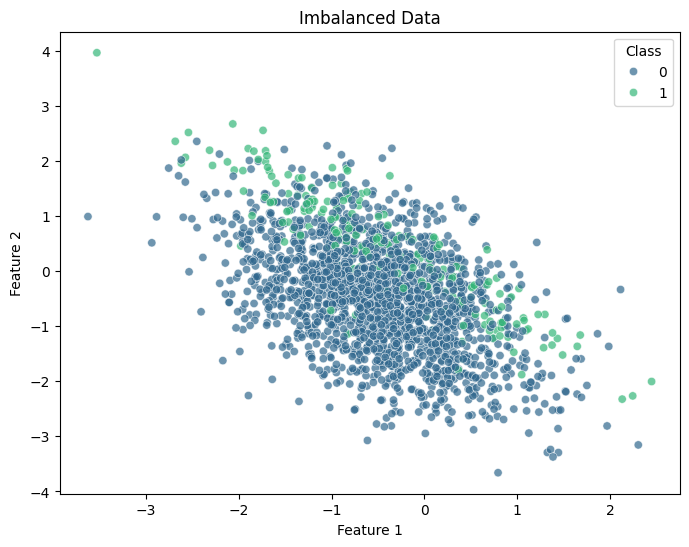

In [20]:
plot_2d(df, str_target='Target', title="Imbalanced Data")

**Class 0** (in blue) dominates the dataset, whereas **class 1** (in green) represents the minority class. While simple in dimensionality and concept structure, **the classification problem might be difficult due the combination of class imbalance and class overlap** (both classes co-exist in a significant portion of the input space).

## **2. Training a Decision Tree and Evaluating Performance Metrics**

Before applying any undersampling or oversampling techniques, we will first determine the baseline results of a Decision Tree trained with the imbalanced data. To that end, we will:

- Divide the dataset into a training and test set (70/30 holdout)
- Normalize the input features
- Train a Decision Tree with the training set
- Evaluate it on the test set
- Output the performance results

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X, y = split_data(df, str_target='Target')

In [27]:
X

,f_0,f_1
0,-0.240675,0.959407
1,-1.715117,-0.207801
2,-1.352256,-2.365398
3,1.029432,-1.710967
4,-0.694094,-1.803002
...,...,...
1995,-0.968572,0.277911
1996,-0.577249,-0.075235
1997,-0.324130,0.093687
1998,-0.881580,-0.558739


In [28]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Name: Target, Length: 2000, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Characteristics of the Training Set
print("Training Set Class Distribution:\n", y_train.value_counts())
print("Proportion of positive samples in the training set: ", round(y_train.value_counts()[1]/len(y_train)*100, 1))

# Characteristics of the Test Set
print("Testing Set Class Distribution:\n", y_test.value_counts())
print("Proportion of positive samples in the test set: ", round(y_test.value_counts()[1]/len(y_test)*100, 1))

Training Set Class Distribution:
 Target
0    1250
1     150
Name: count, dtype: int64
Proportion of positive samples in the training set:  10.7
Testing Set Class Distribution:
 Target
0    536
1     64
Name: count, dtype: int64
Proportion of positive samples in the test set:  10.7


Our **stratified holdout** produced a training and test sets with the same class prevalences, close to 90%-10%, where the **Imbalance Ratio** is kept for both trainig and test sets (**10.7**):
- The **training set** contains **150 minority** class examples and **1250 majority** class examples
- The **test set** contains **64 minority** class examples and **536** majority class examples

 We can also visually compare the sets to determine to what extent the basic data characteristics hold (e.g., data sparsity, class concepts, decision boundaries).

In [34]:
# Visualize Training and Test Partitions
df_train = pd.concat([X_train, y_train], axis=1)
df_train = df_train.reset_index(drop=True)

df_test = pd.concat([X_test, y_test], axis=1)
df_test = df_test.reset_index(drop=True)

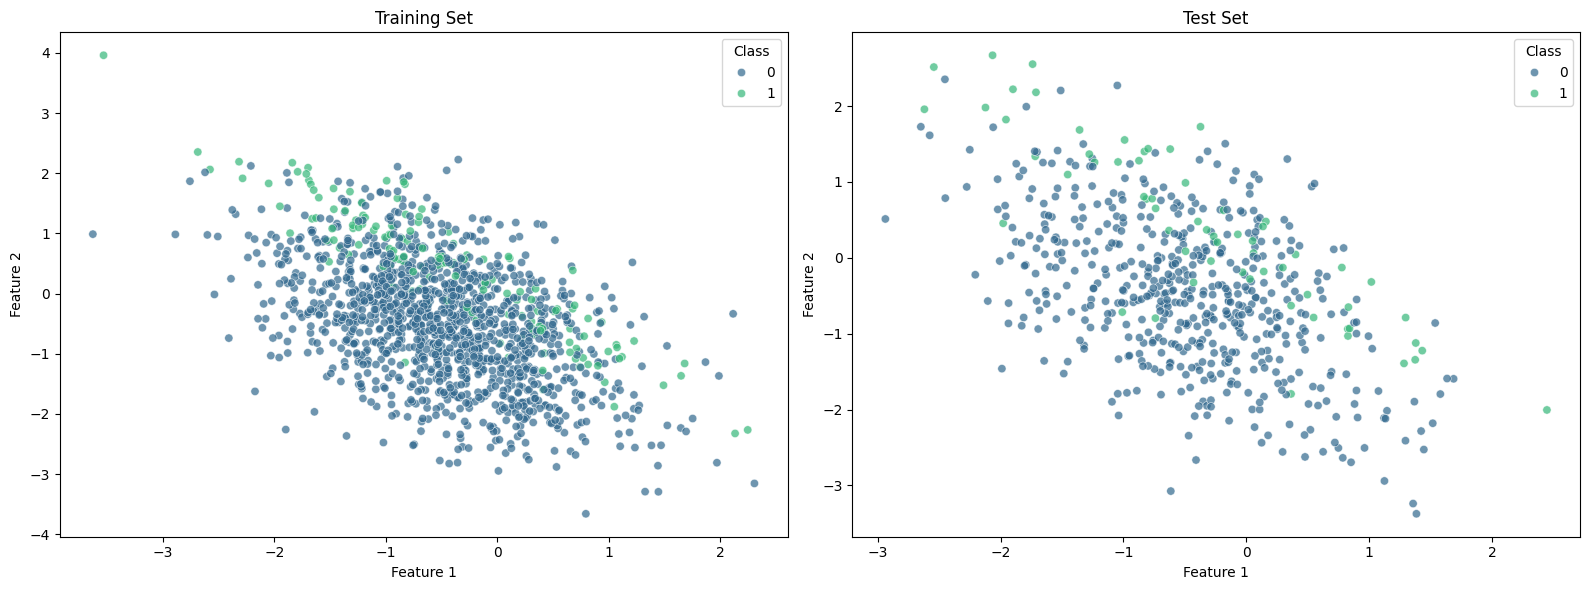

In [35]:
# Plot training and test sets side by side
subplot_2d(df_train, df_test, 'Target', title1="Training Set", title2="Test Set")

We can now proceed to determine the **baseline classification performance** metrics of a simple classifier, such as **Decision Trees**.

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [40]:
# Train decision tree model on training set
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

In [41]:
y_pred

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

We will focus on **baseline performance results**, as follows:

- **Accurary:** $ACC = \frac{TP + TN}{P + N}$

- **Precision:** $Prec = \frac{TP}{PP}$

- **Recall:** $TP = \frac{TP}{P}$

- **F1:** $F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}$



In [42]:
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1': f1_score(y_test, y_pred, pos_label=1)
}

In [43]:
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

Accuracy: 0.86
Precision: 0.32
Recall: 0.28
F1: 0.30


As expected, while **Accuracy is high (86%)**, the results for the positive class are not ideal, with **Recall at 28%** and **F1 at 30%**. In what follows, we will see to what extent using resampling techniques can help improve these results.

## **3. Exploring Undersampling and Oversampling Approaches**


To get started with these resampling techniques, we can first familiarize ourselves with the [imbalanced-learn](https://imbalanced-learn.org/stable/index.html) toolbox, and define some util functions as we did before. In this case, these functions are simply wrappers to use [undersampling](https://imbalanced-learn.org/stable/under_sampling.html) and [oversampling](https://imbalanced-learn.org/stable/over_sampling.html) classes available in [imbalanced-learn](https://imbalanced-learn.org/stable/index.html).

In [47]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [48]:
def random_undersampling(X, y):
    """Undersamples the training data (X) according to RUS."""
    generator = RandomUnderSampler(random_state=42)
    X_res, y_res = generator.fit_resample(X, y)
    return X_res, y_res


def random_oversampling(X, y):
    """Oversamples the training data (X) according to ROS."""
    generator = RandomOverSampler(random_state=42)
    X_res, y_res = generator.fit_resample(X, y)
    return X_res, y_res


def smote_oversampling(X, y, k=5):
    """Applies the SMOTE technique on the training data (X)."""
    generator = SMOTE(random_state=42, k_neighbors=k)
    X_res, y_res = generator.fit_resample(X, y)
    return X_res, y_res

### **3.1. Exploring Random Undersampling (RUS)**


In what follows, we will repeat the previous steps (fitting a classifier and evaluating performance) using different resampling techniques to tackle the class imbalance problem before model training. We start with **RandomUndersampling**, which randomly removes some of the majority class examples to achieve prevalence parity:

In [50]:
from collections import Counter

# Perform Random Undersampling
X_train_rus, y_train_rus = random_undersampling(X_train, y_train)

print("Shape of X_train: ", X_train.shape)
print("Distribution of original training data: ", Counter(y_train))

print("Shape of X_train_rus: ", X_train_rus.shape)
print("Distribution of undersampled training data: ", Counter(y_train_rus))

Shape of X_train:  (1400, 2)
Distribution of original training data:  Counter({0: 1250, 1: 150})
Shape of X_train_rus:  (300, 2)
Distribution of undersampled training data:  Counter({0: 150, 1: 150})


Since the original training set consisted of **150 minority class examples** and **1250 majority class examples**, RUS randomly removes some majority class examples to keep only **150 majority examples** as well. The undersampled dataset now comprises 300 examples with balanced class priors.

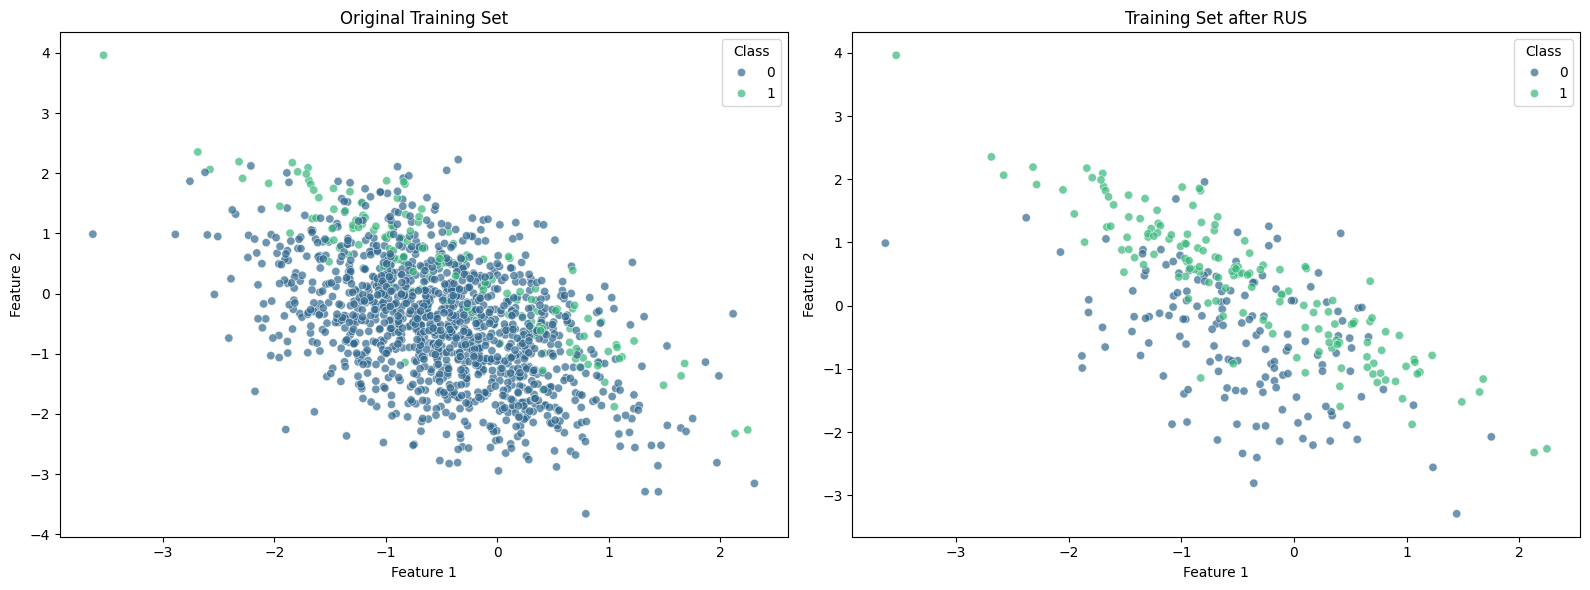

In [51]:
df_train_rus = pd.concat([pd.DataFrame(X_train_rus, columns=['f_0', 'f_1']), y_train_rus], axis=1)
df_train_rus = df_train_rus.reset_index(drop=True)

# Compare the Original Data with RUS Data
subplot_2d(df_train, df_train_rus, 'Target', title1="Original Training Set", title2="Training Set after RUS")

We can visually assess how **all minority class examples (green) are kept after RUS**, whereas a considerable number of **majority class examples (blue) has been removed** from the training.

In [52]:
# Evaluating classification performance with Decision Tree
clf.fit(X_train_rus, y_train_rus)

# Making predictions on the test set
y_pred_after_rus = clf.predict(X_test) # Note that X_test remains untouched!

rus_results = {
    'Accuracy': accuracy_score(y_test, y_pred_after_rus),
    'Precision': precision_score(y_test, y_pred_after_rus, pos_label=1),
    'Recall': recall_score(y_test, y_pred_after_rus, pos_label=1),
    'F1': f1_score(y_test, y_pred_after_rus, pos_label=1)
}

for metric, value in rus_results.items():
    print(f'{metric}: {value:.2f}')

Accuracy: 0.71
Precision: 0.21
Recall: 0.66
F1: 0.32


We notice some **improvement over the minority class**, with an increase in the **Recall (66%)**. However, the overall results are still not promising. We can try to explore different techniques, such as **RandomOversampling**.

### **3.2. Exploring Random Oversampling (ROS)**


Rather than removing majority examples from the training, **Random Oversampling (ROS) inflates the minority class concepts** until the class priors are balanced. To that end, it randomly selects some minority class examples, creates exact replicas of these examples, and adds them to the training data.

In [58]:
# Perform Random Oversampling
X_train_ros, y_train_ros = random_oversampling(X_train, y_train)

print("Shape of X_train: ", X_train.shape)
print("Distribution of original training data: ", Counter(y_train))

print("Shape of X_train_ros: ", X_train_ros.shape)
print("Distribution of oversampled training data: ", Counter(y_train_ros))

Shape of X_train:  (1400, 2)
Distribution of original training data:  Counter({0: 1250, 1: 150})
Shape of X_train_ros:  (2500, 2)
Distribution of oversampled training data:  Counter({0: 1250, 1: 1250})


As expected, the process is contrary to the one applied by RUS. The oversampled dataset now comprises 2500 examples with balanced class priors, where the **150 original minority examples** have been replicated to generate $(1250 - 150) = 1100$ minority examples to inflate the training set.

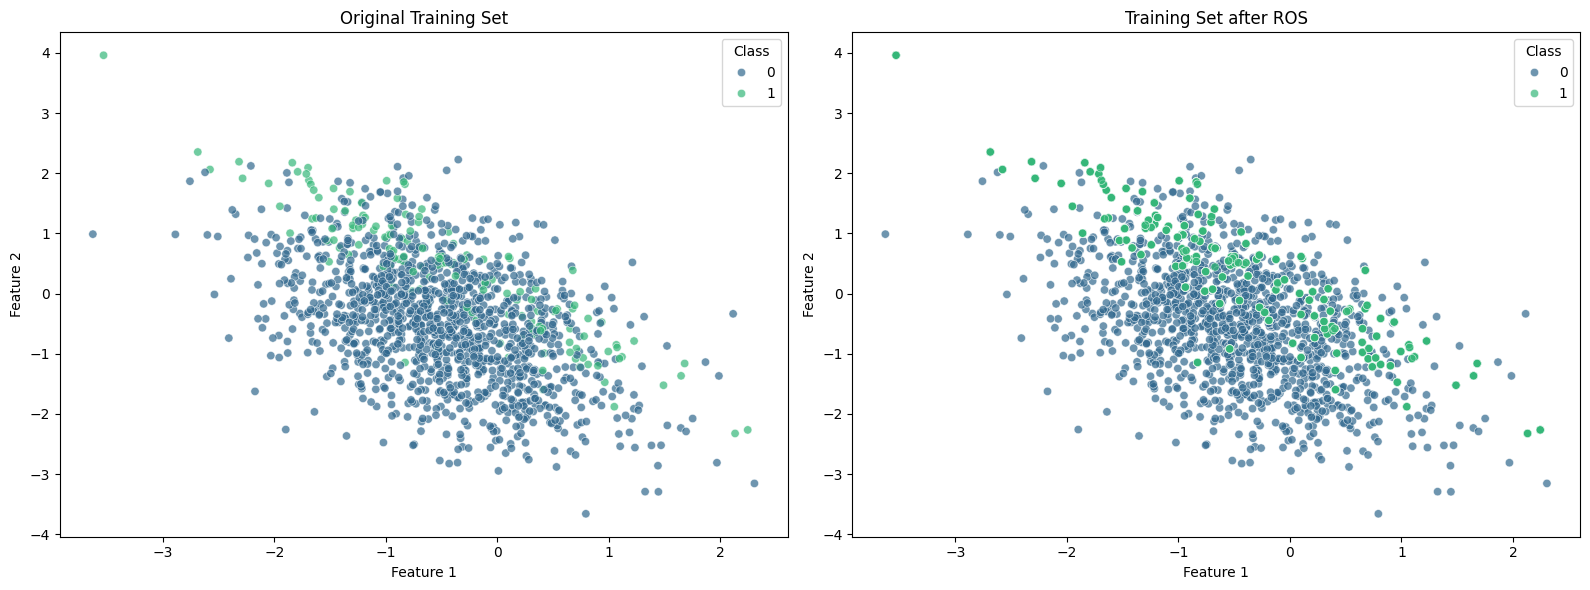

In [54]:
df_train_ros = pd.concat([pd.DataFrame(X_train_ros, columns=['f_0', 'f_1']), y_train_ros], axis=1)
df_train_ros = df_train_ros.reset_index(drop=True)

# Compare the Original Data with ROS Data
subplot_2d(df_train, df_train_ros, 'Target', title1="Original Training Set", title2="Training Set after ROS")

The changes in the dataset are not very clear at first sight due to the **collinearity of minority class examples**. Looking closely, we can see that some minority class examples seem to be highlighted (there are several points plotted "over" each other).

In [55]:
# Evaluating classification performance with Decision Tree
clf.fit(X_train_ros, y_train_ros)

# Making predictions on the test set
y_pred_after_ros = clf.predict(X_test) # Note that X_test remains untouched!

ros_results = {
    'Accuracy': accuracy_score(y_test, y_pred_after_ros),
    'Precision': precision_score(y_test, y_pred_after_ros, pos_label=1),
    'Recall': recall_score(y_test, y_pred_after_ros, pos_label=1),
    'F1': f1_score(y_test, y_pred_after_ros, pos_label=1)
}

for metric, value in ros_results.items():
    print(f'{metric}: {value:.2f}')

Accuracy: 0.86
Precision: 0.31
Recall: 0.27
F1: 0.29


It seems that the **Recall decreased again (27%)**. Since the minority examples are simply repeated samples of the original ones, this drop in performance might be due to one of the problems associated with ROS: **the risk of overfitting the data**, thus performing poorly on the test set.

### **3.3. Exploring SMOTE**


The Synthetic Minority Oversampling Technique (SMOTE) considers a different oversampling approach: it inflates the minority class by creating **new examples along the lines that connect two minority examples in each other's vicinity** (e.g., through interpolation). 

In [59]:
# Applying SMOTE
X_train_smote, y_train_smote = smote_oversampling(X_train, y_train, k=2)

print("Shape of X_train: ", X_train.shape)
print("Distribution of original training data: ", Counter(y_train))

print("Shape of X_train_smote: ", X_train_smote.shape)
print("Distribution of oversampled training data: ", Counter(y_train_smote))

Shape of X_train:  (1400, 2)
Distribution of original training data:  Counter({0: 1250, 1: 150})
Shape of X_train_smote:  (2500, 2)
Distribution of oversampled training data:  Counter({0: 1250, 1: 1250})


Similarly to ROS, the underlying process of **SMOTE augments the minority class with new 1100 minority examples**. However, there is more variability added to the training set, as these new examples are synthetically created based on specified vicinities (in this example $k = 5$ according to the util function defined), rather than exact replicas of existing points.

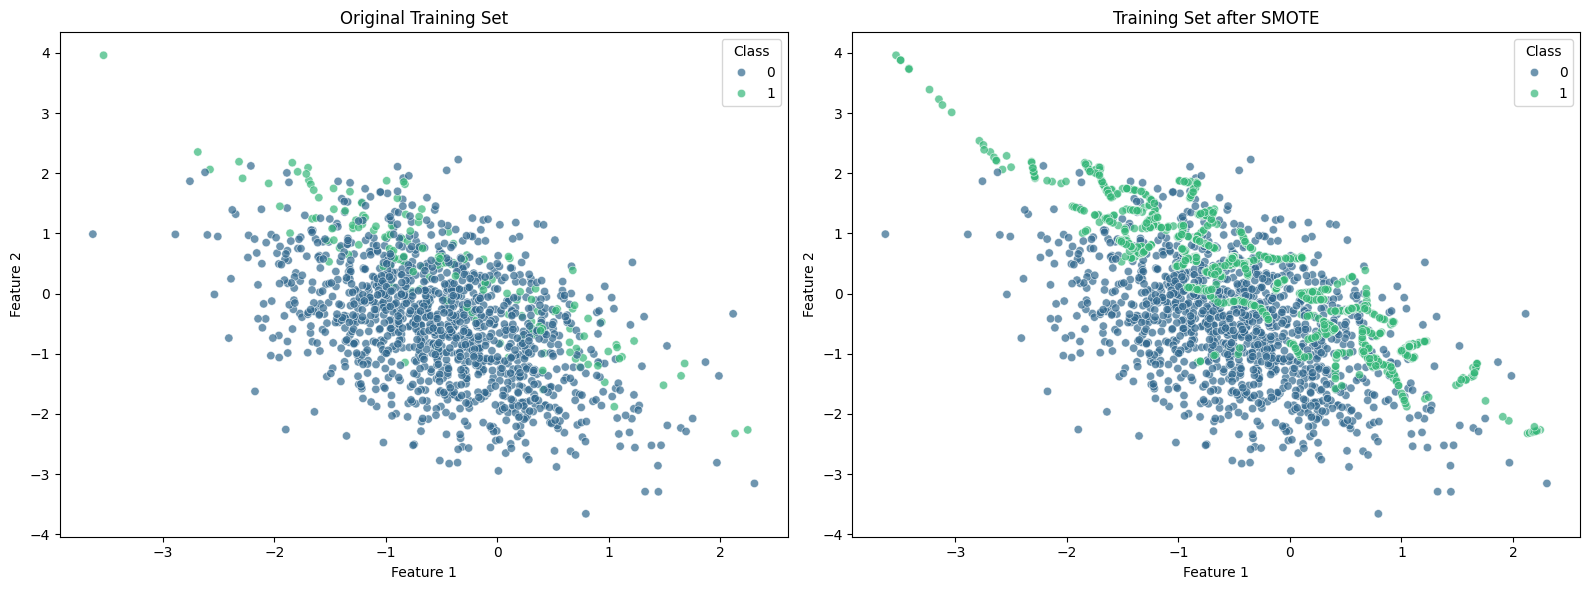

In [60]:
df_train_smote = pd.concat([pd.DataFrame(X_train_smote, columns=['f_0', 'f_1']), y_train_smote], axis=1)
df_train_smote = df_train_smote.reset_index(drop=True)

# Compare the Original data with SMOTE Data
subplot_2d(df_train, df_train_smote, 'Target', title1="Original Training Set", title2="Training Set after SMOTE")

While there is some variability when compared with ROS, note how the data is somewhat created in "straight lines", regardless of the location of minority points (i.e., without taking into account whether some points should be oversampled more often than others). **This exemplifies the problem of overgeneralization associated with SMOTE and SMOTE-like approaches.** Howevwe, while this behaviour can have some negative impact in performance (especially when other difficulty factors are present in the data, such as class overlap), the fact is that SMOTE is still one of the most frequently used techniques for imbalanced learning with overall reasonable results. (Yet, naturally, this will depend on the data characteristics).

In [61]:
# Evaluating classification performance with Decision Tree
clf.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_after_smote = clf.predict(X_test) # Note that X_test remains untouched!

smote_results = {
    'Accuracy': accuracy_score(y_test, y_pred_after_smote),
    'Precision': precision_score(y_test, y_pred_after_smote, pos_label=1),
    'Recall': recall_score(y_test, y_pred_after_smote, pos_label=1),
    'F1': f1_score(y_test, y_pred_after_smote, pos_label=1)
}

for metric, value in smote_results.items():
    print(f'{metric}: {value:.2f}')

Accuracy: 0.82
Precision: 0.27
Recall: 0.41
F1: 0.33


For our domain, considering the particular characteristics of the data (e.g., an impactful are of class overlap), **SMOTE has not provided a significant change** on the baseline results.

### **3.4. Exploring Borderline-SMOTE and ADASYN**

You might further comapre the previous solutions with other oversampling techniques such as [Boderline-SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html#borderlinesmote) and [ADASYN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html#adasyn), or even [other SMOTE variants](https://smote-variants.readthedocs.io/en/latest/). Would these approaches improve the baseline results?

In [63]:
# TODO: YOUR CODE HERE

## **Conclusions**

> **In machine learning there are, unfortunately, no "free lunches".**

We have explored how some resampling strategies can enhance the classification performance of traditional classifiers. However, we need to bear in mind the following:

- It is not guaranteed that oversampling algorithms such as SMOTE (or related) perform well in all scenarios. How well they work will depend on specific domain issues, problem complexity, and data characteristics.
- The default settings in Python modules might not always be effective. Similar to any other machine learning methodology, SMOTE (and other approaches) have their own hyperparameters. These hyperparameters should be optimized for optimal performance.
- In this example, we considered a simple stratified holdout validation stategy (with only one trial). For more realiable estimates, we could consider Stratified Cross Validation, to get average performance and associated uncertainty.
- New resampling methods are being proposed everyday. The key trick to choose the best one is to "match" its properties with the characteristics of the data.
- Althought we have only explored resampling techniques, there are other highly effective strategies to handle imbalanced data. These strategies (e.g., cost-sensitive methods, ensembles, etc.) are worth investigating. Depending on your domain's needs and problem constraints, they might be a better fit to overcome the class imbalance issue.

## **Bibliography**
- To consolidate the concepts discussed herein, please refer to the following:
    - Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). [SMOTE: synthetic minority over-sampling technique](https://www.jair.org/index.php/jair/article/view/10302). Journal of artificial intelligence research, 16, 321-357.
    - López, V., Fernández, A., Moreno-Torres, J. G., & Herrera, F. (2012). [Analysis of preprocessing vs. cost-sensitive learning for imbalanced classification. Open problems on intrinsic data characteristics](https://www.sciencedirect.com/science/article/pii/S0957417411017143?casa_token=BpXVsjewiDAAAAAA:e8wGjDH6cBGV4YAknY1DTr3bVoEjlI8OJc9irVAi8fqhCQH1okg4ID1Mjt0zDaKDxDYCVmbTOA). Expert Systems with Applications, 39(7), 6585-6608.
    - Sáez, J. A., Krawczyk, B., & Woźniak, M. (2016). [Analyzing the oversampling of different classes and types of examples in multi-class imbalanced datasets](https://www.sciencedirect.com/science/article/abs/pii/S0031320316001072). Pattern Recognition, 57, 164-178.
    - Santos, M. S., Soares, J. P., Abreu, P. H., Araujo, H., & Santos, J. (2018). [Cross-validation for imbalanced datasets: avoiding overoptimistic and overfitting approaches [research frontier]](https://ieeexplore.ieee.org/document/8492368). IEEE Computational Intelligence Magazine, 13(4), 59-76.
    - Kovács, G. (2019). [An empirical comparison and evaluation of minority oversampling techniques on a large number of imbalanced datasets](https://www.sciencedirect.com/science/article/abs/pii/S1568494619304429). Applied Soft Computing, 83, 105662. 
    - Kovács, G. (2019). [Smote-variants: A python implementation of 85 minority oversampling techniques](https://www.sciencedirect.com/science/article/pii/S0925231219311622). Neurocomputing, 366, 352-354.